In [6]:
import pandas as pd
import json 
from utils.openai_query import openai_chat
from utils.prompt_factory import make_user_prompt_with_score,  prompt_for_name
from utils.server_model_query import server_model_chat
from utils.llm_analysis_utils import process_analysis, save_progress
from utils.genai_query import query_genai_model
from tqdm import tqdm
import constant
import openai
import os
import logging
import re
%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
## load variables
initialize = True # if True, then initialize the input table with llm names, analysis and score to None 
# Replace with your actual values
config_file = './jsonFiles/name_only_test_gpt_4.json'  # replace with your actual config file 
input_file = 'data/GO_term_analysis/100_selected_go_contaminated.csv' # replace with your actual input file
input_sep = ','  # replace with the separator
set_index = 'GO'  # replace with your column name that you want to set as index or None
gene_column = 'Genes'  # replace with your actual column name for the gene list
gene_sep = ' '  # replace with your actual separator
gene_features = None  # replace with your path to the gene features or None if you don't want to include in the prompt
direct = False # if True, then the prompt will be a direct sentence asking for a name and analysis from the gene set, otherwise default or customized prompt
out_file = 'data/GO_term_analysis/name_only/LLM_processed_only_name_gpt4'  # replace with your actual output file name


# load the config file
with open(config_file) as json_file:
    config = json.load(json_file)

# Load OpenAI key, context, and model used 
openai.api_key = os.environ["OPENAI_API_KEY"]

context = config['CONTEXT']
model = config['MODEL']
temperature = config['TEMP']
max_tokens = config['MAX_TOKENS']
if model.startswith('gpt'):
    rate_per_token = config['RATE_PER_TOKEN']
    DOLLAR_LIMIT = config['DOLLAR_LIMIT']
LOG_FILE = config['LOG_NAME']+'_log.json'

SEED = constant.SEED
column_prefix = model.split('-')[0]

In [23]:
df = pd.read_csv(input_file, sep=input_sep, index_col=set_index)

genes = df.loc['GO:0061740', 'Genes'].split(' ')
print(prompt_for_name(genes))
prompt_test = prompt_for_name(genes)
openai_chat(context, prompt_test, model, temperature, max_tokens, rate_per_token, LOG_FILE, DOLLAR_LIMIT, SEED)


Propose a brief name for the most prominant biological process performed by the system.
    
Be concise, do not use unneccesary words. Be specific, avoid overly general names such as 'the proteins are involved in various cellular processes'
Be factual, do not editorialize.
    

Here are the interacting proteins:

Proteins: HSPA8, LAMP2, CLU.


116


('Chaperone-Mediated Autophagy (CMA)', 'fp_de93422283')

In [26]:
# handle the logger so it create a new one for each model run
def get_logger(filename):
    logger = logging.getLogger(filename)
    logger.setLevel(logging.INFO)
    if not logger.handlers:
        file_handler = logging.FileHandler(filename)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    return logger


def main(df):
    analysis_dict  = {}

    logger = get_logger(f'{out_file}.log')

    i = 0 #used for track progress and saving the file
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        #only process None rows 
        if pd.notna(row[f'{column_prefix} Only Name']):
            continue
        
        gene_data = row[gene_column]
        # if gene_data is not a string, then skip
        if type(gene_data) != str:
            
            logger.warning(f'Gene set {idx} is not a string, skipping')
            continue
        genes = gene_data.split(gene_sep)
        
        if len(genes) >1000:
            logger.warning(f'Gene set {idx} is too big, skipping')
            continue

        try:
            prompt = prompt_for_name(genes)
            # print(prompt)
            finger_print = None
            if model.startswith('gpt'):
                print("Accessing OpenAI API")
                analysis, finger_print = openai_chat(context, prompt, model, temperature, max_tokens, rate_per_token, LOG_FILE, DOLLAR_LIMIT, SEED)
            elif model.startswith('gemini'):
                print("Using Google Gemini API")
                analysis, error_message = query_genai_model(f"{context}\n{prompt}", model, temperature, max_tokens, LOG_FILE) 
            else:
                print("Using server model")
                analysis, error_message= server_model_chat(context, prompt, model, temperature, max_tokens,LOG_FILE, SEED)

            
            if analysis:
                # print(analysis)
                df.loc[idx, f'{column_prefix} Only Name'] = analysis
                analysis_dict[f'{idx}_{column_prefix}'] = analysis
                # Log success with fingerprint
                logger.info(f'Success for {idx} {column_prefix}.')
                if finger_print:
                    logger.info(f'GPT_Fingerprint for {idx}: {finger_print}')
                    
            else:
                logger.error(f'Error for query gene set {idx}: {error_message}')

        except Exception as e:
            logger.error(f'Error for {idx}: {e}')
            continue
        i += 1
        if i % 10 == 0:
            save_progress(df, analysis_dict, out_file)
            # df.to_csv(f'{out_file}.tsv', sep='\t', index=True)
            print(f"Saved progress for {i} genesets")
    # save the final file
    save_progress(df, analysis_dict, out_file)
    

In [27]:
if __name__ == "__main__":
    
    df = pd.read_csv(input_file, sep=input_sep, index_col=set_index)
    column_prefix = 'gpt4_default'
    print(column_prefix)
    
    if initialize:
        df[f'{column_prefix} Only Name'] = None
    main(df)  ## run with the real set 
    
    df.head()


gpt4_default


  0%|          | 0/100 [00:00<?, ?it/s]

Accessing OpenAI API


  1%|          | 1/100 [00:01<01:50,  1.11s/it]

116
Accessing OpenAI API


  2%|▏         | 2/100 [00:02<01:39,  1.02s/it]

184
Accessing OpenAI API


  3%|▎         | 3/100 [00:02<01:24,  1.15it/s]

256
Accessing OpenAI API


  4%|▍         | 4/100 [00:04<01:49,  1.14s/it]

161
Accessing OpenAI API


  5%|▌         | 5/100 [00:05<01:42,  1.08s/it]

237
Accessing OpenAI API


  6%|▌         | 6/100 [00:06<01:49,  1.16s/it]

461
Accessing OpenAI API


  7%|▋         | 7/100 [00:07<01:40,  1.08s/it]

129
Accessing OpenAI API


  8%|▊         | 8/100 [00:08<01:41,  1.11s/it]

453
Accessing OpenAI API


  9%|▉         | 9/100 [00:10<01:49,  1.20s/it]

259
Accessing OpenAI API


 10%|█         | 10/100 [00:10<01:28,  1.02it/s]

117
Saved progress for 10 genesets
Accessing OpenAI API


 11%|█         | 11/100 [00:11<01:32,  1.04s/it]

124
Accessing OpenAI API


 12%|█▏        | 12/100 [00:12<01:31,  1.04s/it]

115
Accessing OpenAI API


 13%|█▎        | 13/100 [00:13<01:31,  1.05s/it]

122
Accessing OpenAI API


 14%|█▍        | 14/100 [00:15<01:44,  1.21s/it]

143
Accessing OpenAI API


 15%|█▌        | 15/100 [00:16<01:43,  1.22s/it]

414
Accessing OpenAI API


 16%|█▌        | 16/100 [00:18<01:48,  1.29s/it]

558
Accessing OpenAI API


 17%|█▋        | 17/100 [00:19<01:47,  1.30s/it]

166
Accessing OpenAI API


 18%|█▊        | 18/100 [00:20<01:37,  1.18s/it]

189
Accessing OpenAI API


 19%|█▉        | 19/100 [00:21<01:37,  1.20s/it]

140
Accessing OpenAI API


 20%|██        | 20/100 [00:22<01:17,  1.03it/s]

116
Saved progress for 20 genesets
Accessing OpenAI API


 21%|██        | 21/100 [00:23<01:21,  1.03s/it]

182
Accessing OpenAI API


 22%|██▏       | 22/100 [00:24<01:23,  1.07s/it]

133
Accessing OpenAI API


 23%|██▎       | 23/100 [00:25<01:17,  1.01s/it]

144
Accessing OpenAI API


 24%|██▍       | 24/100 [00:25<01:05,  1.16it/s]

399
Accessing OpenAI API


 25%|██▌       | 25/100 [00:27<01:15,  1.00s/it]

379
Accessing OpenAI API


 26%|██▌       | 26/100 [00:28<01:17,  1.04s/it]

127
Accessing OpenAI API


 27%|██▋       | 27/100 [00:29<01:15,  1.04s/it]

115
Accessing OpenAI API


 28%|██▊       | 28/100 [00:30<01:21,  1.13s/it]

467
Accessing OpenAI API


 29%|██▉       | 29/100 [00:31<01:12,  1.02s/it]

112
Accessing OpenAI API


 30%|███       | 30/100 [00:32<01:19,  1.13s/it]

256
Saved progress for 30 genesets
Accessing OpenAI API


 31%|███       | 31/100 [00:33<01:06,  1.05it/s]

200
Accessing OpenAI API


 32%|███▏      | 32/100 [00:38<02:25,  2.14s/it]

294
Accessing OpenAI API


 33%|███▎      | 33/100 [00:39<02:01,  1.81s/it]

136
Accessing OpenAI API


 34%|███▍      | 34/100 [00:40<01:47,  1.64s/it]

135
Accessing OpenAI API


 35%|███▌      | 35/100 [00:41<01:32,  1.42s/it]

121
Accessing OpenAI API


 36%|███▌      | 36/100 [00:42<01:19,  1.24s/it]

121
Accessing OpenAI API


 37%|███▋      | 37/100 [00:42<01:09,  1.10s/it]

128
Accessing OpenAI API


 38%|███▊      | 38/100 [00:44<01:08,  1.11s/it]

133
Accessing OpenAI API


 39%|███▉      | 39/100 [00:45<01:04,  1.06s/it]

153
Accessing OpenAI API


 40%|████      | 40/100 [00:45<00:55,  1.09it/s]

135
Saved progress for 40 genesets
Accessing OpenAI API


 41%|████      | 41/100 [00:47<01:05,  1.11s/it]

140
Accessing OpenAI API


 42%|████▏     | 42/100 [00:48<01:15,  1.31s/it]

153
Accessing OpenAI API


 43%|████▎     | 43/100 [00:50<01:15,  1.33s/it]

153
Accessing OpenAI API


 44%|████▍     | 44/100 [00:51<01:07,  1.20s/it]

127
Accessing OpenAI API


 45%|████▌     | 45/100 [00:52<01:09,  1.27s/it]

167
Accessing OpenAI API


 46%|████▌     | 46/100 [00:53<01:02,  1.16s/it]

120
Accessing OpenAI API


 47%|████▋     | 47/100 [00:54<01:04,  1.22s/it]

503
Accessing OpenAI API


 48%|████▊     | 48/100 [00:55<00:59,  1.14s/it]

114
Accessing OpenAI API


 49%|████▉     | 49/100 [00:56<00:51,  1.01s/it]

138
Accessing OpenAI API


 50%|█████     | 50/100 [00:57<00:49,  1.01it/s]

126
Saved progress for 50 genesets
Accessing OpenAI API


 51%|█████     | 51/100 [00:58<00:42,  1.14it/s]

119
Accessing OpenAI API


 52%|█████▏    | 52/100 [00:59<00:42,  1.13it/s]

146
Accessing OpenAI API


 53%|█████▎    | 53/100 [01:00<00:49,  1.05s/it]

133
Accessing OpenAI API


 54%|█████▍    | 54/100 [01:01<00:44,  1.04it/s]

185
Accessing OpenAI API


 55%|█████▌    | 55/100 [01:02<00:47,  1.05s/it]

123
Accessing OpenAI API


 56%|█████▌    | 56/100 [01:03<00:41,  1.06it/s]

115
Accessing OpenAI API


 57%|█████▋    | 57/100 [01:04<00:40,  1.06it/s]

385
Accessing OpenAI API


 58%|█████▊    | 58/100 [01:06<00:52,  1.26s/it]

170
Accessing OpenAI API


 59%|█████▉    | 59/100 [01:07<00:49,  1.20s/it]

167
Accessing OpenAI API


 60%|██████    | 60/100 [01:07<00:41,  1.05s/it]

394
Saved progress for 60 genesets
Accessing OpenAI API


 61%|██████    | 61/100 [01:09<00:46,  1.19s/it]

264
Accessing OpenAI API


 62%|██████▏   | 62/100 [01:10<00:46,  1.22s/it]

131
Accessing OpenAI API


 63%|██████▎   | 63/100 [01:11<00:43,  1.17s/it]

236
Accessing OpenAI API


 64%|██████▍   | 64/100 [01:12<00:40,  1.11s/it]

169
Accessing OpenAI API


 65%|██████▌   | 65/100 [01:13<00:33,  1.04it/s]

110
Accessing OpenAI API


 66%|██████▌   | 66/100 [01:13<00:28,  1.20it/s]

111
Accessing OpenAI API


 67%|██████▋   | 67/100 [01:14<00:28,  1.14it/s]

276
Accessing OpenAI API


 68%|██████▊   | 68/100 [01:15<00:25,  1.26it/s]

126
Accessing OpenAI API


 69%|██████▉   | 69/100 [01:16<00:28,  1.10it/s]

459
Accessing OpenAI API


 70%|███████   | 70/100 [01:18<00:33,  1.10s/it]

151
Saved progress for 70 genesets
Accessing OpenAI API


 71%|███████   | 71/100 [01:18<00:28,  1.01it/s]

192
Accessing OpenAI API


 72%|███████▏  | 72/100 [01:19<00:24,  1.15it/s]

128
Accessing OpenAI API


 73%|███████▎  | 73/100 [01:20<00:25,  1.04it/s]

117
Accessing OpenAI API


 74%|███████▍  | 74/100 [01:21<00:26,  1.02s/it]

175
Accessing OpenAI API


 75%|███████▌  | 75/100 [01:22<00:25,  1.00s/it]

144
Accessing OpenAI API


 76%|███████▌  | 76/100 [01:24<00:30,  1.27s/it]

140
Accessing OpenAI API


 77%|███████▋  | 77/100 [01:25<00:24,  1.07s/it]

177
Accessing OpenAI API


 78%|███████▊  | 78/100 [01:26<00:26,  1.19s/it]

562
Accessing OpenAI API


 79%|███████▉  | 79/100 [01:27<00:22,  1.06s/it]

118
Accessing OpenAI API


 80%|████████  | 80/100 [01:28<00:21,  1.05s/it]

127
Saved progress for 80 genesets
Accessing OpenAI API


 81%|████████  | 81/100 [01:30<00:27,  1.47s/it]

240
Accessing OpenAI API


 82%|████████▏ | 82/100 [01:32<00:24,  1.34s/it]

148
Accessing OpenAI API


 83%|████████▎ | 83/100 [01:34<00:29,  1.75s/it]

265
Accessing OpenAI API


 84%|████████▍ | 84/100 [01:35<00:23,  1.46s/it]

126
Accessing OpenAI API


 85%|████████▌ | 85/100 [01:35<00:17,  1.16s/it]

149
Accessing OpenAI API


 86%|████████▌ | 86/100 [01:37<00:18,  1.32s/it]

139
Accessing OpenAI API


 87%|████████▋ | 87/100 [01:39<00:18,  1.42s/it]

144
Accessing OpenAI API


 88%|████████▊ | 88/100 [01:41<00:18,  1.55s/it]

328
Accessing OpenAI API


 89%|████████▉ | 89/100 [01:42<00:15,  1.42s/it]

160
Accessing OpenAI API


 90%|█████████ | 90/100 [01:43<00:13,  1.38s/it]

202
Saved progress for 90 genesets
Accessing OpenAI API


 91%|█████████ | 91/100 [01:44<00:11,  1.24s/it]

131
Accessing OpenAI API


 92%|█████████▏| 92/100 [01:44<00:08,  1.02s/it]

167
Accessing OpenAI API


 93%|█████████▎| 93/100 [01:46<00:07,  1.10s/it]

181
Accessing OpenAI API


 94%|█████████▍| 94/100 [01:48<00:07,  1.32s/it]

345
Accessing OpenAI API


 95%|█████████▌| 95/100 [01:49<00:06,  1.21s/it]

285
Accessing OpenAI API


 96%|█████████▌| 96/100 [01:50<00:04,  1.13s/it]

198
Accessing OpenAI API


 97%|█████████▋| 97/100 [01:50<00:03,  1.07s/it]

114
Accessing OpenAI API


 98%|█████████▊| 98/100 [01:51<00:02,  1.06s/it]

133
Accessing OpenAI API


 99%|█████████▉| 99/100 [01:52<00:01,  1.04s/it]

116
Accessing OpenAI API


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]

513
Saved progress for 100 genesets


In [32]:
# check the time 
import json 
with open('logs/name_only_gpt_4_log.json') as json_file:
    data = json.load(json_file)

time_use = data['time_taken_total']
time_per_query = time_use/data['runs']
cost = data['dollars_spent']
dollor_per_query = cost/data['runs']
print(f'Time per query: {time_per_query} seconds')
print(f'Dollor per query: {dollor_per_query} dollars')


Time per query: 1.1425293884655037 seconds
Dollor per query: 0.005976534653465346 dollars


In [3]:
## run semantic similarities on GO names vs the llm name
from semanticSimFunctions import getSentenceEmbedding
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm
import pickle

SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

nameOnly_df = pd.read_csv('data/GO_term_analysis/name_only/LLM_processed_only_name_gpt4.tsv', sep='\t', index_col='GO')
with open('./data/all_go_terms_3to100_embeddings_dict.pkl', 'rb') as handle:
    all_go_terms_embeddings_dict = pickle.load(handle)
 

df = nameOnly_df.copy()
df['LLM_name_GO_term_sim'] = None
for ind, row in tqdm(df.iterrows(), total=df.shape[0]):

    GO_term = row['Term_Description'] # the actual GO term
    # get the name column 
    name_col = [col for col in df.columns if 'name' in col.lower()][0]
    # print(name_col)
    LLM_name = row[name_col] # the LLM name
    # print(LLM_name)
    # get llm name embedding
    LLM_name_emb = getSentenceEmbedding(LLM_name, SapBERT_tokenizer, SapBERT_model)
    GO_emb = all_go_terms_embeddings_dict[GO_term]
    # calculate the cosine similarity
    sim = cosine_similarity(LLM_name_emb, GO_emb)[0][0]
    df.loc[ind, 'LLM_name_GO_term_sim'] = sim
df

100%|██████████| 100/100 [00:04<00:00, 20.60it/s]


,Genes,Gene_Count,Term_Description,50perc_contaminated_Genes,100perc_contaminated_Genes,gpt4_default Only Name,LLM_name_GO_term_sim
GO,,,,,,,
GO:0061740,HSPA8 LAMP2 CLU,3,protein targeting to lysosome involved in chap...,CLU RAB28 PRAMEF19,VEZT TERF1 TTC3,Chaperone-Mediated Autophagy (CMA),0.761196
GO:0045056,LRP1 PICALM CLTC USO1 VPS35 FCMR RAB5A AGER IG...,21,transcytosis,CLTC VPS35 FCGRT PTAFR RAB11B USO1 LRP1 LRP2 L...,LDAH ADH1A MAP3K6 PABIR1 AMY1C PRSS54 LGALS12 ...,Endocytic Pathway Regulation,0.459203
GO:0141085,PPP2CA CD36 MARK4 CPTP TREM2 TLR6 ATAT1 FBXL2 ...,39,regulation of inflammasome-mediated signaling ...,PYDC2 BRCC3 USP50 MAVS IRGM PYDC1 GBP2 ZDHHC12...,TBC1D24 NIPSNAP2 IL1RL2 EGF PSMG2 GCSAML LIN7A...,Innate Immune Signaling Regulation,0.611902
GO:0036148,CRLS1 SERAC1 PLA2G4D PLA2G4F LPGAT1 LPCAT4 PLA...,10,phosphatidylglycerol acyl-chain remodeling,JMJD7-PLA2G4B LPGAT1 PLA2G2F PLA2G4F CRLS1 IMM...,EIF3B GID8 ARPC5 KLHL3 SPDEF PRMT9 PTPN9 AP4E1...,Phospholipid Remodeling and Metabolism,0.751917
GO:1901797,MIF SIRT1 TWIST1 DYRK1A MUC1 ARMC10 MARCHF7 CD...,33,negative regulation of signal transduction by ...,MDM2 CD74 SNAI1 MUC1 TAF9 PRKN SNAI2 RNF34 HAP...,RAB40AL BAG3 CGGBP1 ZNF583 ZFYVE19 USP17L21 AT...,Cellular Stress Response Regulation,0.390415
...,...,...,...,...,...,...,...
GO:1900368,PUM1 MAEL TIAL1 RIPK1 TP53 FXR1 BCDIN3D FMR1 A...,25,regulation of post-transcriptional gene silenc...,BMP4 ZMPSTE24 MAEL PUM2 ELAVL1 ZFP36 LIN28B IL...,GPR75-ASB3 ELOC ADORA2B RPL41 PFDN5 PPP1R12C C...,Post-transcriptional Gene Regulation,0.770571
GO:2000524,LILRB2 LILRB4 CD160,3,negative regulation of T cell costimulation,LILRB4 RIPK1 RASSF2,ATOH7 DRAM1 TOGARAM2,Immunomodulatory Receptor Signaling,0.396955
GO:2000556,IL18 ARID5A TBX21 SLAMF1 IL1R1 IL1B XCL1 IL18R1,8,positive regulation of T-helper 1 cell cytokin...,IL18 XCL1 SLAMF1 IL1R1 RPS6KA3 OR9Q1 OR52M1 ZFP36,PTH2 MGAT4C POM121 KRTAP4-9 DEFA1 SRPRA U2AF1 F2,Th1 Immune Response Activation,0.733239


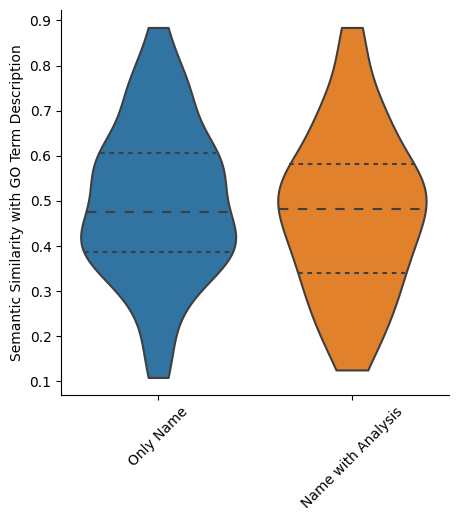

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# compare llm_go sim with the default pipeline 
default_df = pd.read_csv('./data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_4.tsv', sep='\t', index_col='GO')

comparison_df = pd.merge(df[['LLM_name_GO_term_sim']], default_df[['LLM_name_GO_term_sim']], left_index=True, right_index=True, how='inner')

# Rename columns for clarity
comparison_df.columns = ['LLM_name_GO_term_sim_nameOnly', 'LLM_name_GO_term_sim_namewithAnalysis']

fig, ax = plt.subplots(figsize=(5,5))
sns.violinplot(data=comparison_df, ax=ax, inner='quartile', cut=0)
ax.set_xticklabels(['Only Name', 'Name with Analysis'], rotation=45)
ax.set_ylabel('Semantic Similarity with GO Term Description')
sns.despine()



In [17]:
combined_df = pd.merge(df, default_df[['gpt_4_default Name', 'LLM_name_GO_term_sim']], left_index=True, right_index=True, how='inner')


100%|██████████| 100/100 [00:05<00:00, 18.00it/s]


<Axes: ylabel='Name_only_vs_Name_w_ana_sim'>

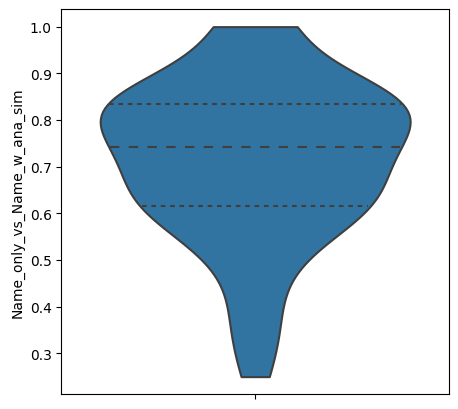

In [18]:
for ind, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    name_only = row['gpt4_default Only Name']
    name_w_ana = row['gpt_4_default Name']
    name_only_emb = getSentenceEmbedding(name_only, SapBERT_tokenizer, SapBERT_model)
    name_w_ana_emb = getSentenceEmbedding(name_w_ana, SapBERT_tokenizer, SapBERT_model)
    sim = cosine_similarity(name_only_emb, name_w_ana_emb)[0][0]
    combined_df.loc[ind, 'Name_only_vs_Name_w_ana_sim'] = sim
    
    
fig, ax = plt.subplots(figsize=(5,5))
sns.violinplot(data=combined_df, y='Name_only_vs_Name_w_ana_sim', ax=ax, inner='quartile', cut=0)